In [1]:
import os
import sys
import torch
import subprocess
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
    version_str="".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    !pip install iopath
    if sys.platform.startswith("linux"):
        print("Trying to install wheel for PyTorch3D")
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
        pip_list = !pip freeze
        need_pytorch3d = not any(i.startswith("pytorch3d==") for  i in pip_list)
    if need_pytorch3d:
        print(f"failed to find/install wheel for {version_str}")
if need_pytorch3d:
    print("Installing PyTorch3D from source")
    !pip install ninja
    !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [2]:
# Import necessary libraries
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
from IPython.display import clear_output

# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)

In [3]:
# Set the cuda device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [4]:
# Load the mesh (clipMesh.obj)
verts, faces_idx, _ = load_obj("/home/exouser/pose_estim/clipestimator/data/mesh/clipMesh.obj")
faces = faces_idx.verts_idx

/home/exouser/anaconda3/envs/blvenv/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: /home/exouser/pose_estim/clipestimator/data/mesh/Item.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [5]:
# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object for the clipMesh.
clip_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures
)

# Initialize a perspective camera.
cameras = FoVPerspectiveCameras(device=device)

# Set blend parameters for silhouette rendering
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Rasterization settings for silhouette rendering
raster_settings_silhouette = RasterizationSettings(
    image_size=256,  # Match the reference image size
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma,
    faces_per_pixel=25,
)

# Silhouette renderer
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

# Rasterization settings for Phong rendering (for visualization)
raster_settings_phong = RasterizationSettings(
    image_size=256,  # Match the reference image size
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Lighting settings for Phong rendering
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))

# Phong renderer
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings_phong
    ),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)


In [6]:
# Select the viewpoint using spherical angles
distance = 25   # distance from camera to the object
elevation = 50.0   # angle of elevation in degrees
azimuth = 40.0  # No rotation so the camera is positioned on the +Z axis.

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

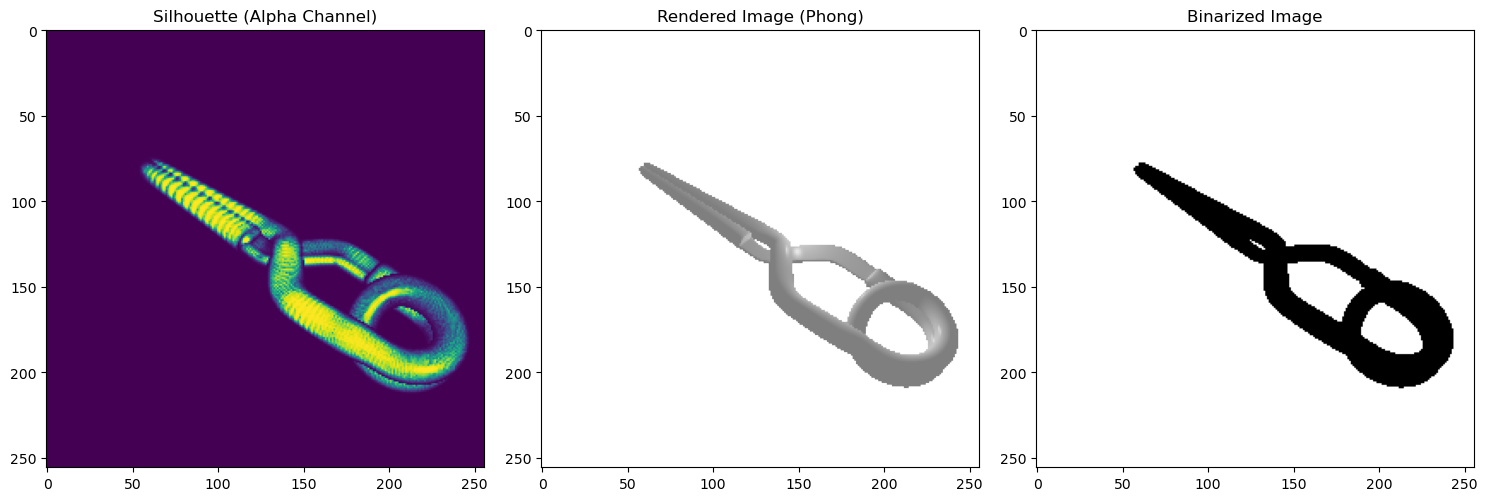

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Render the mesh providing the values of R and T.
silhouette = silhouette_renderer(meshes_world=clip_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=clip_mesh, R=R, T=T)

silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

# Binarize the image_ref
binarization_threshold = 0.95  # Adjust this threshold as needed (e.g., 0.5 for mid-range)
image_ref_gray = np.mean(image_ref.squeeze()[..., :3], axis=-1)  # Convert to grayscale
image_ref_binary = (image_ref_gray > binarization_threshold).astype(np.uint8)

# Plot the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(silhouette.squeeze()[..., 3])  # Alpha channel of the silhouette
plt.title("Silhouette (Alpha Channel)")
plt.grid(False)

plt.subplot(1, 3, 2)
plt.imshow(image_ref.squeeze())
plt.title("Rendered Image (Phong)")
plt.grid(False)

plt.subplot(1, 3, 3)
plt.imshow(image_ref_binary, cmap='gray')  # Binarized image in black and white
plt.title("Binarized Image")
plt.grid(False)

plt.tight_layout()
plt.show()

In [10]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer

        # Ensure image_ref is in float32 format and device-compatible
        image_ref = torch.from_numpy(image_ref).to(meshes.device).float()

        # Extract the alpha channel and ensure it's 2D
        if image_ref.ndim == 4:  # If image_ref has shape (N, H, W, C)
            self.image_ref = image_ref[..., 3]  # Extract alpha channel -> Shape: (N, H, W)
        elif image_ref.ndim == 3:  # If image_ref has shape (H, W, C)
            self.image_ref = image_ref[:, :, 3]  # Extract alpha channel -> Shape: (H, W)
        else:
            raise ValueError("Invalid image_ref shape. Expected 3D or 4D tensor.")

        # Add batch and channel dimensions to make it compatible with interpolate
        self.image_ref = self.image_ref.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)

        # Resize reference image to match the renderer output size (e.g., 16x16)
        self.image_ref = F.interpolate(
            self.image_ref,  # Shape: (1, 1, H, W)
            size=(16, 16),  # Match renderer output size
            mode='bilinear',
            align_corners=False
        ).squeeze(0).squeeze(0)  # Remove batch and channel dims -> Shape: (16, 16)

        # Create an optimizable parameter for the x, y, z position of the camera.
        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([3.0, 6.9, +2.5], dtype=np.float32)).to(meshes.device)
        )

    def forward(self):
        # Render the image using the updated camera position.
        R = look_at_rotation(self.camera_position[None, :], device=self.device)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]

        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T)

        # Extract the alpha channel of the rendered image
        image_alpha = image[..., 3]  # Shape: (1, H, W)

        # Use a smooth approximation for binarization (e.g., sigmoid)
        binarization_threshold = 0.5
        image_binary = torch.sigmoid((image_alpha - binarization_threshold) * 10)  # Shape: (1, 16, 16)

        print("Rendered image_binary shape:", image_binary.shape)
        print("Reference image_ref shape:", self.image_ref.shape)

        # Expand the reference image to match the size of image_binary
        target_binary = self.image_ref.unsqueeze(0).expand_as(image_binary)  # Shape: (N, H, W)

        # Use binary cross-entropy as a differentiable loss
        loss = torch.nn.functional.binary_cross_entropy(image_binary, target_binary)
        return loss, image

In [11]:
# Initialize the model and optimizer
filename_output = "./clipMesh_optimization_demo.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

model = Model(meshes=clip_mesh, renderer=silhouette_renderer, image_ref=image_ref_binary).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

ValueError: Invalid image_ref shape. Expected 3D or 4D tensor.

Rendered image_binary shape after resizing: torch.Size([1, 256, 256])


RuntimeError: The expanded size of the tensor (256) must match the existing size (16) at non-singleton dimension 2.  Target sizes: [1, 256, 256].  Tensor sizes: [1, 16, 16]

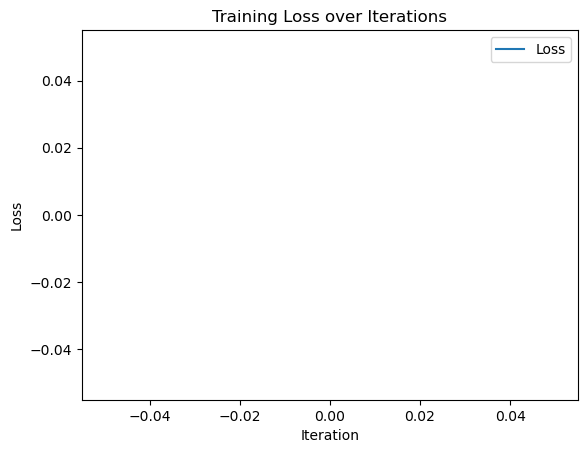

In [32]:
# Initialize lists to store loss values for plotting
loss_values = []

# Set up the plot for loss curve
plt.ion()
fig, ax = plt.subplots()
line, = ax.plot([], [], label="Loss")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title("Training Loss over Iterations")
ax.legend()

# Training loop
num_iterations = 200
final_image_binary = None
for i in range(num_iterations):
    optimizer.zero_grad()
    loss, rendered_image = model()  # Forward pass
    loss.backward()    # Backward pass
    optimizer.step()   # Optimization step

    # Store the loss for plotting
    loss_values.append(loss.item())

    # Update the plot
    line.set_data(range(len(loss_values)), loss_values)
    ax.relim()
    ax.autoscale_view()

    clear_output(wait=True)
    display(fig)

    # Print loss every 10 iterations
    if i % 10 == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")

    # Save the final rendered image for binary visualization
    if i == num_iterations - 1:
        binarization_threshold = 0.5
        image_alpha = rendered_image[..., 3]  # Extract alpha channel
        final_image_binary = (image_alpha > binarization_threshold).float().squeeze().cpu().numpy()

# Display final results
plt.ioff()
fig, axarr = plt.subplots(1, 3, figsize=(15, 5))

# Plot loss curve
axarr[0].plot(loss_values)
axarr[0].set_title("Loss Curve")
axarr[0].set_xlabel("Iteration")
axarr[0].set_ylabel("Loss")

print("Shape of model.image_ref:", model.image_ref.shape)
print("Shape of final_image_binary:", final_image_binary.shape)


# Display target binary image
target_binary = model.image_ref.cpu().numpy().reshape(256, 256)  # Ensure 2D shape
axarr[1].imshow(target_binary, cmap="gray")
axarr[1].set_title("Target Binary Image")
axarr[1].axis("off")

# Display final pose-estimated binary image
final_image_binary = final_image_binary.reshape(256, 256)  # Ensure 2D shape
axarr[2].imshow(final_image_binary, cmap="gray")
axarr[2].set_title("Final Pose-Estimated Binary Image")
axarr[2].axis("off")

plt.tight_layout()
plt.show()



  0%|          | 0/200 [00:00<?, ?it/s]

RuntimeError: The expanded size of the tensor (256) must match the existing size (16) at non-singleton dimension 2.  Target sizes: [1, 256, 256].  Tensor sizes: [1, 16, 16]

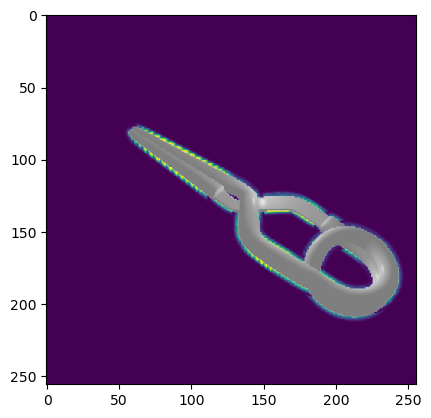

In [11]:
# Optimization loop
plt.imshow(silhouette.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.imshow(image_ref.squeeze())

loop = tqdm(range(200))
for i in loop:
    optimizer.zero_grad()
    loss, _ = model()
    loss.backward()
    optimizer.step()

    loop.set_description('Optimizing (loss %.4f)' % loss.data)

    if loss.item() < 2:
        break

    # Save outputs to create a GIF.
    if i % 10 == 0:
        R = look_at_rotation(model.camera_position[None, :], device=model.device)
        T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]
        image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
        image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        image = img_as_ubyte(image)
        writer.append_data(image)

        plt.figure()
        plt.imshow(image[..., :3])
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        plt.axis("off")

writer.close()